In [1]:
import pandas as pd
from tqdm import tqdm, tqdm_notebook, tqdm_pandas

tqdm.pandas()

# Load

In [2]:
df = pd.read_csv('amazon_reviews_sample.csv')
df = df[['score', 'review']]
df.head()

,score,review
0,1,Stuning even for the non-gamer: This sound tr...
1,1,The best soundtrack ever to anything.: I'm re...
2,1,Amazing!: This soundtrack is my favorite musi...
3,1,Excellent Soundtrack: I truly like this sound...
4,1,"Remember, Pull Your Jaw Off The Floor After H..."


In [3]:
df['char_count'] = df['review'].progress_apply(lambda row: len(row))
df['word_count'] = df['review'].progress_apply(lambda row: len(row.split()))

100%|██████████| 10000/10000 [00:00<00:00, 171480.95it/s]


In [4]:
df.describe()

,score,char_count,word_count
count,10000.000000,10000.000000,10000.000000
mean,0.490300,441.702600,79.553200
std,0.499931,239.243635,43.023095
min,0.000000,104.000000,14.000000
25%,0.000000,241.000000,43.000000
50%,0.000000,394.000000,71.000000
75%,1.000000,608.000000,109.000000
max,1.000000,1018.000000,212.000000


# Preprocessing

In [5]:
df.corr()

,score,char_count,word_count
score,1.000000,-0.044603,-0.051935
char_count,-0.044603,1.000000,0.989204
word_count,-0.051935,0.989204,1.000000


In [6]:
import re
import string
import nltk
import spacy
from nltk.corpus import stopwords

nltk.download('stopwords')
english_stopwords = stopwords.words('english')
english_stopwords = set(english_stopwords)

nlp = spacy.load('en_core_web_sm')

def collapse_same_letters(row):
    row = re.sub(r'([a-z])\1{2,}', '\g<1>', row)
    return row

def remove_stop_words(row):
    words = row.split(' ')
    row = ' '.join([word for word in words if word not in english_stopwords])
    return row

def preprocessing(row):
    row = row.lower()
    row = row.replace('\n', ' ')
    row = row.replace('\t', ' ')
    
    row = collapse_same_letters(row)    
    row = remove_stop_words(row)
        
    row = re.sub(r'[^a-z ]', ' ', row)
    row = re.sub(r'[a-z]{35,}', ' ', row)
    row = re.sub(r' {2,}', ' ', row)
    row = row.strip()
    
    return row

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dmitry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df['preprocessed'] = df['review'].progress_apply(preprocessing)
df['preprocessed'] = df['preprocessed'].progress_apply(lambda row: ' '.join([w.lemma_ for w in nlp(row)]))

df['pp_wc'] = df['preprocessed'].progress_apply(lambda x: len([word for word in x.split(' ') if word is not '']))

df = df[(df['word_count'] > 0)]
df.head()

100%|██████████| 10000/10000 [00:00<00:00, 172402.19it/s]


,score,review,char_count,word_count,preprocessed,pp_wc
0,1,Stuning even for the non-gamer: This sound tr...,429,80,stun even non gamer sound track beautiful pain...,44
1,1,The best soundtrack ever to anything.: I'm re...,512,97,good soundtrack ever anything I m read lot rev...,54
2,1,Amazing!: This soundtrack is my favorite musi...,763,129,amazing soundtrack favorite music time hand do...,79
3,1,Excellent Soundtrack: I truly like this sound...,746,118,excellent soundtrack truly like soundtrack enj...,77
4,1,"Remember, Pull Your Jaw Off The Floor After H...",484,87,remember pull jaw floor hear it play game know...,51


In [8]:
for i, row in df[:2].iterrows():
    print('review: ', row['review'])
    print('preprocessed review: ', row['preprocessed'])
    print()
    print()

review:   Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^

preprocessed review:  stun even non gamer sound track beautiful paint senery mind well would recomend even people hate vid game music play game chrono cross game ever play good music back away crude keyboarding take fresher step grate guitar soulful orchestra would impress anyone care listen


review:   The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless 

# Balance analysis

In [9]:
df.describe()

,score,char_count,word_count,pp_wc
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.490300,441.702600,79.553200,43.433700
std,0.499931,239.243635,43.023095,23.721701
min,0.000000,104.000000,14.000000,4.000000
25%,0.000000,241.000000,43.000000,24.000000
50%,0.000000,394.000000,71.000000,39.000000
75%,1.000000,608.000000,109.000000,59.000000
max,1.000000,1018.000000,212.000000,144.000000


In [10]:
step = 10
df['wc_group'] = df['pp_wc'].apply(lambda x: int(x / step))
positive_df = df[df['score'] == 1]
negative_df = df[df['score'] == 0]
df.corr()

,score,char_count,word_count,pp_wc,wc_group
score,1.000000,-0.044603,-0.051935,-0.033837,-0.035627
char_count,-0.044603,1.000000,0.989204,0.981901,0.974718
word_count,-0.051935,0.989204,1.000000,0.970073,0.963161
pp_wc,-0.033837,0.981901,0.970073,1.000000,0.992786
wc_group,-0.035627,0.974718,0.963161,0.992786,1.000000


In [11]:
from functools import reduce

positive_stats = positive_df['wc_group'].value_counts(sort=False).to_frame()
negative_stats = negative_df['wc_group'].value_counts(sort=False).to_frame()

stats = [positive_stats, negative_stats]
stats_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), stats)
stats_df.columns = ['positive', 'negative']
stats_df = stats_df.sort_index()

stats_df

,positive,negative
0,14,13
1,923,751
2,930,903
3,746,861
4,612,689
5,494,572
6,391,446
7,301,358
8,245,277
9,177,169


In [12]:
dataframes = [positive_df, negative_df]
max_word_count = 150

result_dfs = []
for dataframe in dataframes:
    restricted_df = dataframe[dataframe['pp_wc'] < max_word_count]
    for name, group in restricted_df.groupby('wc_group'):
        if name not in stats_df.index:
            continue
        
        n_samples = stats_df.loc[int(name)].min()
        sampled_df = group.sample(n=n_samples)
        
        result_dfs.append(sampled_df)
        
balanced_df = reduce(lambda left, right: left.append(right), result_dfs)
balanced_df.head()

,score,review,char_count,word_count,preprocessed,pp_wc,wc_group
9194,1,Good service: I was pleased with the conditio...,109,20,good service please condition book speed recei...,9,0
9989,1,classic: i got this for my dad. it is super c...,104,22,classic get dad super creepy worth watch watch...,9,0
881,1,Good read................. ............... .....,282,35,good read good read,4,0
6818,1,"1984: Love the book, very appropriate for the...",104,18,love book appropriate time live in arrive cond...,9,0
5157,1,Good: I have not really had a chance to use t...,108,22,good really chance use daughter state work well,8,0


In [13]:
balanced_df.describe()

,score,char_count,word_count,pp_wc,wc_group
count,9364.000000,9364.000000,9364.000000,9364.000000,9364.000000
mean,0.500000,441.636267,79.516980,43.429090,3.892354
std,0.500027,238.720632,42.899482,23.648165,2.371362
min,0.000000,104.000000,15.000000,4.000000,0.000000
25%,0.000000,242.000000,44.000000,24.000000,2.000000
50%,0.500000,392.000000,71.000000,38.000000,3.000000
75%,1.000000,607.000000,109.000000,59.000000,5.000000
max,1.000000,1018.000000,207.000000,118.000000,11.000000


In [14]:
balanced_df.corr()

,score,char_count,word_count,pp_wc,wc_group
score,1.000000e+00,-0.008719,-0.015567,0.001120,4.599764e-15
char_count,-8.719341e-03,1.000000,0.989088,0.982253,9.750298e-01
word_count,-1.556676e-02,0.989088,1.000000,0.970078,9.630943e-01
pp_wc,1.119995e-03,0.982253,0.970078,1.000000,9.927225e-01
wc_group,4.599764e-15,0.975030,0.963094,0.992723,1.000000e+00


# Эмбеддинги

In [15]:
import numpy as np
import mmap
embeddings_path = 'fasttext.wiki-news-300d-1M.vec'

def get_num_lines(file_path):
    fp = open(file_path, "r+")
    buf = mmap.mmap(fp.fileno(), 0)
    lines = 0
    while buf.readline():
        lines += 1
    return lines

embeddings_dict = {}
with open(embeddings_path, 'r', encoding='utf-8') as file:
    for line in tqdm_notebook(file, total=get_num_lines(embeddings_path)):
        values = line.split()
        word = values[0].lower()
        if word in embeddings_dict:
            continue
        
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = vector

D:\SoftwareProjects\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/999995 [00:00<?, ?it/s]

## Split dataframes

In [16]:
def split_dataframe(dataframe):
    test = dataframe.sample(n=500)
    train = dataframe.loc[~dataframe.index.isin(test.index)].sample(frac=1)
    
    return (train, test)

def get_train_test_sets(dataframe):
    positive_sentiment_df = dataframe[dataframe['score'] == 1]
    negative_sentiment_df = dataframe[dataframe['score'] == 0]
    
    positive_split = split_dataframe(positive_sentiment_df)
    negative_split = split_dataframe(negative_sentiment_df)

    train = positive_split[0].append(negative_split[0])
    test = positive_split[1].append(negative_split[1])
    return (train, test)

## Naive approach - bag of word representation

In [17]:
def average_vectorizations(row):
    vectors = []
    for word in row.split():
        if word in embeddings_dict:
            vectors.append(embeddings_dict[word])
    
    result_vector = np.mean(vectors, axis=0)
    return result_vector

In [18]:
naive_df = balanced_df.copy()
naive_df['vector'] = naive_df['preprocessed'].progress_apply(average_vectorizations)

100%|██████████| 9364/9364 [00:00<00:00, 15350.45it/s]


In [19]:
train, test = get_train_test_sets(naive_df)

def get_arrayed_data(df_set):
    setX = np.stack(df_set['vector'].values, axis=0)
    setY = np.stack(df_set['score'].values, axis=0)        
    return (setX, setY)

trainX, trainY = get_arrayed_data(train)
testX, testY = get_arrayed_data(test)

# Different models comparison

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import NearestCentroid

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import f1_score

In [41]:
# We can take the whole dataset since we use cross-validation based approach (HalvingGridSearchCV)
trainX, trainY = get_arrayed_data(naive_df)
print(trainX.shape, trainY.shape)

(9364, 300) (9364,)


In [44]:
def perform_search(classifier, params, verbosity=1, aggressive_elimination=False):
    gsh = HalvingGridSearchCV(estimator=classifier, param_grid=params, scoring='f1_weighted',
                              verbose=verbosity, aggressive_elimination=aggressive_elimination)
    gsh.fit(trainX, trainY)
    print(f'Best score: {gsh.best_score_} for config {gsh.best_params_}')
    return gsh

In [29]:
svc_linear = SVC(kernel='linear')
svc_linear_params = {
    'kernel': ['linear'],
    'C': list(np.logspace(-3, 0, 5)) + [1, 2, 5, 10, 15]
}

gsh = perform_search(svc_linear, svc_linear_params)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1040
max_resources_: 9364
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 1040
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 1
n_candidates: 4
n_resources: 3120
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 9360
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best score: 0.827887275033086 for config {'C': 2, 'kernel': 'linear'}


In [30]:
svc_rbf = SVC(kernel='rbf')
svc_rbf_params = {
    'kernel': ['rbf'],
    'C': list(np.logspace(-3, 0, 5)) + [1, 2, 5, 10, 20, 50, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 2, 3, 5]
}

svc_rbf_gsh = perform_search(svc_rbf, svc_rbf_params)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 115
max_resources_: 9364
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 84
n_resources: 115
Fitting 5 folds for each of 84 candidates, totalling 420 fits
----------
iter: 1
n_candidates: 28
n_resources: 345
Fitting 5 folds for each of 28 candidates, totalling 140 fits
----------
iter: 2
n_candidates: 10
n_resources: 1035
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 3
n_candidates: 4
n_resources: 3105
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 9315
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best score: 0.8450569995182512 for config {'C': 2, 'gamma': 5, 'kernel': 'rbf'}


In [31]:
decision_tree = DecisionTreeClassifier()
decision_tree_params = {
    'criterion': ['gini'],
    'max_depth': [None, 3, 5, 10, 15, 20, 30, 50],
    'min_samples_split': [7, 10, 12, 18, 25, 50],
    'min_samples_leaf': [15, 20, 25, 50, 100]
}

decision_tree_gsh = perform_search(decision_tree, decision_tree_params)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 115
max_resources_: 9364
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 240
n_resources: 115
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
----------
iter: 1
n_candidates: 80
n_resources: 345
Fitting 5 folds for each of 80 candidates, totalling 400 fits
----------
iter: 2
n_candidates: 27
n_resources: 1035
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 3
n_candidates: 9
n_resources: 3105
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 4
n_candidates: 3
n_resources: 9315
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best score: 0.6862362775912602 for config {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 15, 'min_samples_split': 12}


In [32]:
ada_boost = AdaBoostClassifier()
ada_boost_params = {
    'n_estimators': [75, 100, 125, 150, 200],
    'learning_rate': [0.01, 0.03, 0.1, 0.16, 0.215443469, 0.27, 0.5]
}

ada_boost_gsh = perform_search(ada_boost, ada_boost_params)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 346
max_resources_: 9364
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 35
n_resources: 346
Fitting 5 folds for each of 35 candidates, totalling 175 fits
----------
iter: 1
n_candidates: 12
n_resources: 1038
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 4
n_resources: 3114
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 9342
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best score: 0.7989568993838501 for config {'learning_rate': 0.27, 'n_estimators': 200}


In [33]:
knn = KNeighborsClassifier()
knn_params = {
    'n_neighbors': [3, 4, 5, 7, 10, 15, 20, 25],
    'weights': ['distance', 'uniform'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'p': [1, 2]
}

knn_gsh = perform_search(knn, knn_params)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 38
max_resources_: 9364
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 384
n_resources: 38
Fitting 5 folds for each of 384 candidates, totalling 1920 fits
----------
iter: 1
n_candidates: 128
n_resources: 114
Fitting 5 folds for each of 128 candidates, totalling 640 fits
----------
iter: 2
n_candidates: 43
n_resources: 342
Fitting 5 folds for each of 43 candidates, totalling 215 fits
----------
iter: 3
n_candidates: 15
n_resources: 1026
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 4
n_candidates: 5
n_resources: 3078
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 5
n_candidates: 2
n_resources: 9234
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best score: 0.7377511788164492 for config {'algorithm': 'kd_tree', 'leaf_size': 40, 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}


In [36]:
random_forest = RandomForestClassifier()
random_forest_params = {
    'n_estimators': [100, 150, 200],
    'criterion': ['gini'],
    'max_depth': [3, 5, 10, 20],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [5, 10, 20]
}

random_forest_gsh = perform_search(random_forest, random_forest_params)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 115
max_resources_: 9364
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 108
n_resources: 115
Fitting 5 folds for each of 108 candidates, totalling 540 fits
----------
iter: 1
n_candidates: 36
n_resources: 345
Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------
iter: 2
n_candidates: 12
n_resources: 1035
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 3
n_candidates: 4
n_resources: 3105
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 9315
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best score: 0.7903357525775175 for config {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 150}


In [23]:
trainX, trainY = get_arrayed_data(train)
testX, testY = get_arrayed_data(test)

## Sklearn models comparison

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    ]

classifiers = [
    KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1, weights='distance'),
    SVC(kernel="linear", C=2),
    SVC(kernel="rbf", gamma=5, C=2),
    DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=15, min_samples_split=12),
    RandomForestClassifier(criterion='gini', max_depth=20, n_estimators=150, min_samples_leaf=5, min_samples_split=15),
    AdaBoostClassifier(n_estimators=200, learning_rate=0.27)
]

In [42]:
for name, clf in zip(names, classifiers):
    print(name)
    clf.fit(trainX, trainY)
    
    scores = cross_val_score(clf, trainX, trainY, cv=5, scoring='f1_weighted')
    avg_score = np.mean(scores)
    
    print(f'Average F1: {avg_score}, total: {scores}')    
    print()

Nearest Neighbors
Average F1: 0.743635500956519, total: [0.7596474  0.77567091 0.73237034 0.73614053 0.71434832]

Linear SVM
Average F1: 0.8268958288339506, total: [0.82740858 0.846171   0.82219819 0.82052475 0.81817662]

RBF SVM
Average F1: 0.8493057282479761, total: [0.85156943 0.86596556 0.84516571 0.83929268 0.84453527]

Decision Tree
Average F1: 0.688081215508412, total: [0.69025955 0.70221786 0.68311116 0.69610014 0.66871737]

Random Forest
Average F1: 0.7917824242215824, total: [0.79646292 0.81892642 0.78050387 0.78371572 0.77930319]

AdaBoost
Average F1: 0.7953312953272024, total: [0.79599504 0.81097997 0.78959358 0.79544979 0.78463809]



# Ensemble models

In [24]:
import itertools
import functools

from sklearn.ensemble import VotingClassifier, StackingClassifier

In [37]:
factories = [
    lambda: ('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1, weights='distance')),
    lambda: ('lsvc', SVC(kernel="linear", C=2, probability=True)),
    lambda: ('rbf-svc', SVC(kernel="rbf", gamma=5, C=2, probability=True)),
    lambda: ('dt', DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=15, min_samples_split=12)),
    lambda: ('rf', RandomForestClassifier(criterion='gini', max_depth=20, n_estimators=150, min_samples_leaf=5, min_samples_split=15)),
    #lambda: ('ada', AdaBoostClassifier(n_estimators=200, learning_rate=0.27))
]

In [38]:
factories_combinations = functools.reduce(lambda x, y: x + y, [list(itertools.combinations(factories, i)) for i in [3]])
estimators = [list(map(lambda x: x(), list(comb))) for comb in factories_combinations]
len(estimators)

10

In [82]:
voting_classifier = VotingClassifier(estimators=[])
voting_params = {
    'estimators': estimators,
    'voting': ['hard', 'soft']
}

voting_gsh = perform_search(voting_classifier, voting_params)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 309
max_resources_: 8364
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 309
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 1
n_candidates: 18
n_resources: 927
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 6
n_resources: 2781
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 8343
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best score: 0.8412221436449302 for config {'estimators': [('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('ada', AdaBoostClassifier(learning_rate=0.27, n_estimators=200))], 'voting': 'soft'}


In [39]:
from sklearn.linear_model import LogisticRegression

stacking_lr_classifier = StackingClassifier(estimators=[])
stacking_lr_params = {
    'estimators': estimators,
    'final_estimator': [LogisticRegression()],
    
    'final_estimator__penalty': ['l2'],
    'final_estimator__C': [0.03],
}

stacking_lr_gsh = perform_search(stacking_lr_classifier, stacking_lr_params, 2)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1040
max_resources_: 9364
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 1040
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True))], final_estimator=LogisticRegression(), final_estimator__C=0.03, final_estimator__penalty=l2; total time=   3.7s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True))], final_estimator=LogisticRegression(), final_estimator__C=0.03, final_estimator__penalty=l2; total time=   4.3s
[CV] 

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=LogisticRegression(), final_estimator__C=0.03, final_estimator__penalty=l2; total time=   6.8s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=LogisticRegression(), final_estimator__C=0.03, final_estimator__penalty=l2; total time=   7.0s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
              

[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=LogisticRegression(), final_estimator__C=0.03, final_estimator__penalty=l2; total time=   6.6s
[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=LogisticRegression(), final_estimator__C=0.03, final_estimator__penalty=l2; total time=   6.6s
[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassif

[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=LogisticRegression(), final_estimator__C=0.03, final_estimator__penalty=l2; total time=  30.4s
[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=LogisticRegression(), final_estimator__C=0.03, final_estimator__penalty=l2; total time=  30.7s
[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=LogisticRegression(), final_estimator__C=0.03, final_estimator__penalty=l2; total time=  30.7s
[CV] END estimators=[(

In [47]:
stacking_dt_classifier = StackingClassifier(estimators=[])
stacking_dt_params = {
    'estimators': estimators,
    'final_estimator': [DecisionTreeClassifier()],
    
    'final_estimator__criterion': ['gini'],
    'final_estimator__max_depth': [5, 10],
    'final_estimator__min_samples_split': [5, 10],
    'final_estimator__min_samples_leaf': [5, 10]
}

stacking_dt_gsh = perform_search(stacking_dt_classifier, stacking_dt_params, 2)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 346
max_resources_: 9364
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 80
n_resources: 346
Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=5, final_estimator__min_samples_split=5; total time=   0.5s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True))], final_estimator=DecisionTreeC

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   0.5s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   0.5s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_n

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   0.5s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   0.5s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=   0.3s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=   0.3s
[CV] END estim

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=   0.3s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=   0.3s
[CV] END est

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=5, final_estimator__min_samples_split=10; total time=   2.6s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_sample

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=5, final_estimator__min_samples_split=5; total time=   2.2s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_sampl

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   2.1s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=5, final_estimator__min_samples_split

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   0.4s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   0.4s
[CV] END estimators=[(

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=   0.4s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=   0.4s
[CV] END estimators=[(

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=   2.3s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10,

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=5, final_estimator__min_samples_split=10; total time=   2.2s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=5

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=5, final_estimator__min_samples_split=5; total time=   2.1s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterio

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   2.1s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criter

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=   2.1s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criter

[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=5, final_estimator__min_samples_split=10; total time=   0.5s
[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=   0.5s
[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, m

[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=5, final_estimator__min_samples_split=10; total time=   0.5s
[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=   0.5s
[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5,

[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=5, final_estimator__min_samples_split=10; total time=   2.3s
[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=5, final_estimator__min_samples_split=10; total time=   2.4s
[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', 

[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=5, final_estimator__min_samples_split=10; total time=   2.3s
[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=5, final_estimator__min_samples_split=10; total time=   2.3s
[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc'

[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=5, final_estimator__min_samples_split=5; total time=   2.2s
[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=5, final_estimator__min_samples_split=10; total time=   2.2s
[CV] END esti

[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=5, final_estimator__min_samples_split=5; total time=   2.4s
[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=5, final_estimator__min_samples_split=5; total time=   2.3s
[CV] END est

[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   2.6s
[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   3.3s
[CV] END

[CV] END estimators=[('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   2.3s
[CV] END estimators=[('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   2.3s
[CV] END estimators=

[CV] END estimators=[('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=   2.4s
[CV] END estimators=[('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=   2.4s
[CV] END estimators=

[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   6.5s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=   2.1s
[CV] END es

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   3.8s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   3.9s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n

[CV] END estimators=[('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   7.7s
[CV] END estimators=[('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   8.0s
[CV] END estimator

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=   7.6s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_le

[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=   6.6s
[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=   6.8s
[CV] END e

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   2.1s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   2.1s
[CV] END est

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   4.2s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=10; total time=   4.2s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_n

[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=   9.4s
[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=   9.4s
[CV] END estimators=[('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', 

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=  45.0s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=  45.2s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_n

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time=  48.9s
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=10, final_estimator__min_samples_leaf=1

[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10, final_estimator__min_samples_split=5; total time= 6.5min
[CV] END estimators=[('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1,
                     weights='distance')), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150))], final_estimator=DecisionTreeClassifier(), final_estimator__criterion=gini, final_estimator__max_depth=5, final_estimator__min_samples_leaf=10,

## Summary
Ensemble models did not perform better than RBF SVM model.

1. **RBF SVM** (SVC(kernel="rbf", gamma=5, C=2)) **Average F1: 0.8493057282479761**

2. **StackingClassifier with LogisticRegression** ({'estimators': [('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=15, p=1, weights='distance')), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('rf', RandomForestClassifier (max_depth=20, min_samples_leaf=5, min_samples_split=15, n_estimators=150))], 'final_estimator': LogisticRegression(C=0.03), 'final_estimator__C': 0.03, 'final_estimator__penalty': 'l2'}) **Average F1: 0.8481494286607708**

3. **StackingClassifier with DecisionTreeClassifier** ({'estimators': [('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=12))], 'final_estimator': DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=10), 'final_estimator__criterion': 'gini', 'final_estimator__max_depth': 5, 'final_estimator__min_samples_leaf': 10, 'final_estimator__min_samples_split': 10}) **Average F1: 0.8470160341015888**

4. **VotingClassifier** ({'estimators': [('lsvc', SVC(C=2, kernel='linear', probability=True)), ('rbf-svc', SVC(C=2, gamma=5, probability=True)), ('ada', AdaBoostClassifier(learning_rate=0.27, n_estimators=200))], 'voting': 'soft'}) **Average F1: 0.8412221436449302**

# Neural Network
Having base model (RBF SVC) achieve F1=0.8493, next goal is to surpass it with neural network.

In [50]:
sequential_df = balanced_df.copy()
sequential_df.to_csv('sequential.csv')

In [ ]:
#sequential_df = pd.read_csv('sequential.csv')

In [53]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(len(embeddings_dict.keys()))
tokenizer.fit_on_texts(tqdm_notebook(embeddings_dict.keys()))

sequential_df['sequences'] = sequential_df['preprocessed'].progress_apply(lambda x: tokenizer.texts_to_sequences([x])[0])
sequential_df['seq_length'] = sequential_df['sequences'].progress_apply(lambda x: len(x))

max_sequence_length = sequential_df['seq_length'].max()
sequential_df['padded_sequences'] = sequential_df['sequences'].progress_apply(lambda x: pad_sequences([x], max_sequence_length)[0])

sequential_df = sequential_df[sequential_df['seq_length'] > 0]

D:\SoftwareProjects\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/830462 [00:00<?, ?it/s]

100%|██████████| 9364/9364 [00:00<00:00, 40713.34it/s]


In [58]:
allowed_outputs = list(df['score'].unique())
outputs_index = {x:i for i, x in enumerate(allowed_outputs)}
print(outputs_index)

from tensorflow.keras.utils import to_categorical

sequential_df[f'output'] = sequential_df[f'score'].apply(lambda x: outputs_index[x]) 
sequential_df[f'output'] = sequential_df[f'output'].apply(lambda x: to_categorical(x, num_classes=len(outputs_index)))
sequential_df.head()

{1: 0, 0: 1}


,score,review,char_count,word_count,preprocessed,pp_wc,wc_group,sequences,seq_length,padded_sequences,output
9194,1,Good service: I was pleased with the conditio...,109,20,good service please condition book speed recei...,9,0,"[449, 477, 2642, 3884, 356, 585, 12653, 127, 4...",9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.0]"
9989,1,classic: i got this for my dad. it is super c...,104,22,classic get dad super creepy worth watch watch...,9,0,"[3643, 1287, 6809, 184, 9253, 2977, 1736, 1736...",9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.0]"
881,1,Good read................. ............... .....,282,35,good read good read,4,0,"[449, 759, 449, 759]",4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.0]"
6818,1,"1984: Love the book, very appropriate for the...",104,18,love book appropriate time live in arrive cond...,9,0,"[805, 356, 2292, 83, 706, 28, 18457, 3884, 12685]",9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.0]"
5157,1,Good: I have not really had a chance to use t...,108,22,good really chance use daughter state work well,8,0,"[449, 5176, 4230, 440, 3890, 167, 272, 69]",8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.0]"


In [59]:
def split_dataframe(dataframe):
    test = dataframe.sample(n=500)
    train = dataframe.loc[~dataframe.index.isin(test.index)].sample(frac=1)
    
    return (train, test)

def get_train_test_sets(dataframe):
    positive_sentiment_df = dataframe[dataframe['score'] == 1]
    negative_sentiment_df = dataframe[dataframe['score'] == 0]
    
    positive_split = split_dataframe(positive_sentiment_df)
    negative_split = split_dataframe(negative_sentiment_df)

    train = positive_split[0].append(negative_split[0])
    test = positive_split[1].append(negative_split[1])
    return (train, test)

In [60]:
train, test = get_train_test_sets(sequential_df)

def get_arrayed_data(df_set):
    setX = np.stack(df_set['padded_sequences'].values, axis=0)
    setY = np.stack(df_set['output'].values, axis=0)        
    return (setX, setY)

trainX, trainY = get_arrayed_data(train)
testX, testY = get_arrayed_data(test)

In [62]:
import json

with open('model/input-map.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer.word_index, ensure_ascii=False))
    
with open('model/input-sequence-length.txt', 'w', encoding='utf-8') as f:
    f.write(json.dumps(int(max_sequence_length), ensure_ascii=False))
    
one_hot_map = {int(v): int(k) for k, v in outputs_index.items()}
with open('model/output-map.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(one_hot_map, ensure_ascii=False))

## Neural network preparations

In [63]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history, title=''):
    colors = ['r', 'g', 'b', 'k']
    metrics= ['f1', 'precision', 'recall', 'acc']
    
    x = range(1, len(history['acc']) + 1)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.ylim(0, 1.1)
    for i, name in enumerate(metrics):
        plt.plot(x, history[name], colors[i], label=name) 
    plt.title(f'Training {title}')
    plt.legend()
        
    plt.subplot(1, 2, 2)
    plt.ylim(0, 1.1)
    for i, name in enumerate(metrics):
        name = f'val_{name}'
        plt.plot(x, history[name], colors[i], label=name)
    plt.title(f'Validation {title}')
    plt.legend()

In [64]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers

In [65]:
token_count = len(tokenizer.word_index) + 1
token_count

662480

In [66]:
from tensorflow.keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def f1(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    return 2*((precision_value*recall_value)/(precision_value+recall_value+K.epsilon()))

In [69]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))
for word, i in tqdm_notebook(tokenizer.word_index.items()):
    if word in embeddings_dict:
        embedding_matrix[i] = embeddings_dict[word]
        
embedding_layer = Embedding(len(tokenizer.word_index) + 1, 300,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    #embeddings_regularizer=regularizers.l2(0.001),
                    trainable=False)

D:\SoftwareProjects\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/662479 [00:00<?, ?it/s]

In [88]:
inp = Input((max_sequence_length,))
x = embedding_layer(inp)
x = BatchNormalization()(x)

# x = Conv1D(filters=4, kernel_size=3, padding='same', activation='relu',
#            kernel_regularizer=regularizers.l1(0.001),
#            bias_regularizer=regularizers.l1(0.001))(x)
# x = BatchNormalization()(x)
# x = AveragePooling1D(pool_size=2)(x)
# x = Dropout(0.1)(x)
# 
# x = Flatten()(x)

x = LSTM(2, activity_regularizer=regularizers.l1(0.0001), return_sequences=True)(x)
x = BatchNormalization()(x)

x = LSTM(2, activity_regularizer=regularizers.l1(0.0001), return_sequences=True)(x)
x = BatchNormalization()(x)

x = LSTM(2, activity_regularizer=regularizers.l1(0.0001), return_sequences=True)(x)
x = BatchNormalization()(x)

x = LSTM(2, activity_regularizer=regularizers.l1(0.0001))(x)
x = BatchNormalization()(x)

out = Dense(trainY.shape[1], activation='softmax')(x)
model = Model(inp, out)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', f1, precision, recall])

In [89]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 117)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 117, 300)          198744000 
_________________________________________________________________
batch_normalization_15 (Batc (None, 117, 300)          1200      
_________________________________________________________________
lstm_8 (LSTM)                (None, 117, 2)            2424      
_________________________________________________________________
batch_normalization_16 (Batc (None, 117, 2)            8         
_________________________________________________________________
lstm_9 (LSTM)                (None, 117, 2)            40        
_________________________________________________________________
batch_normalization_17 (Batc (None, 117, 2)            8   

In [90]:
save_best = ModelCheckpoint('model/best_weights_val_f1.hdf5', save_best_only=True, monitor='val_f1', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_f1', mode='min', factor=0.2, patience=5, verbose=1, cooldown=3)

history = model.fit(trainX, trainY, batch_size=64, validation_data=(testX, testY), callbacks=[save_best, reduce_lr], epochs=20, verbose=1)

Train on 8364 samples, validate on 1000 samples
Epoch 1/20
8364/8364 [==============================] - 32s 4ms/sample - loss: 0.7756 - acc: 0.5023 - f1: 0.5025 - precision: 0.5025 - recall: 0.5025 - val_loss: 0.7067 - val_acc: 0.5000 - val_f1: 0.5117 - val_precision: 0.5117 - val_recall: 0.5117
Epoch 2/20
8364/8364 [==============================] - 23s 3ms/sample - loss: 0.7113 - acc: 0.5450 - f1: 0.5450 - precision: 0.5450 - recall: 0.5450 - val_loss: 0.7061 - val_acc: 0.5250 - val_f1: 0.5338 - val_precision: 0.5338 - val_recall: 0.5338
Epoch 3/20
8364/8364 [==============================] - 22s 3ms/sample - loss: 0.6580 - acc: 0.6279 - f1: 0.6282 - precision: 0.6282 - recall: 0.6282 - val_loss: 0.6860 - val_acc: 0.5450 - val_f1: 0.5551 - val_precision: 0.5551 - val_recall: 0.5551
Epoch 4/20
8364/8364 [==============================] - 22s 3ms/sample - loss: 0.5379 - acc: 0.7429 - f1: 0.7432 - precision: 0.7432 - recall: 0.7432 - val_loss: 1.0879 - val_acc: 0.5790 - val_f1: 0.5889 -

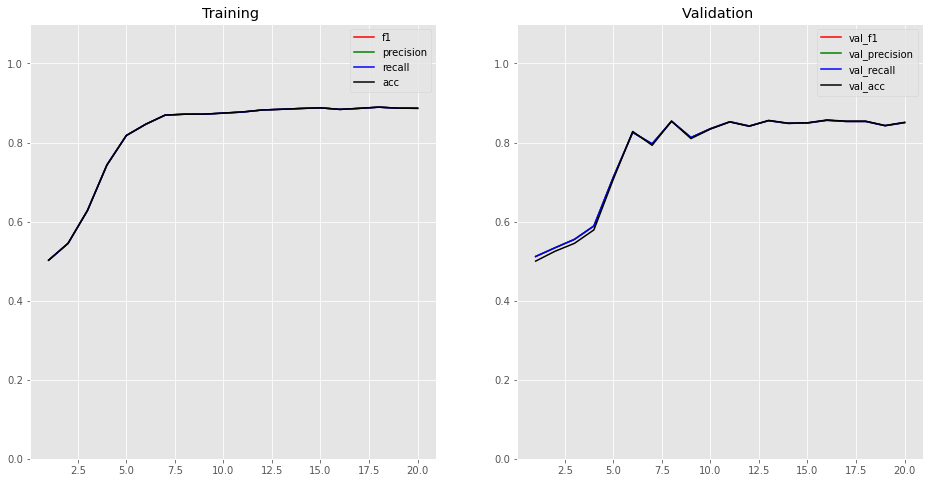

In [91]:
plot_history(history.history)

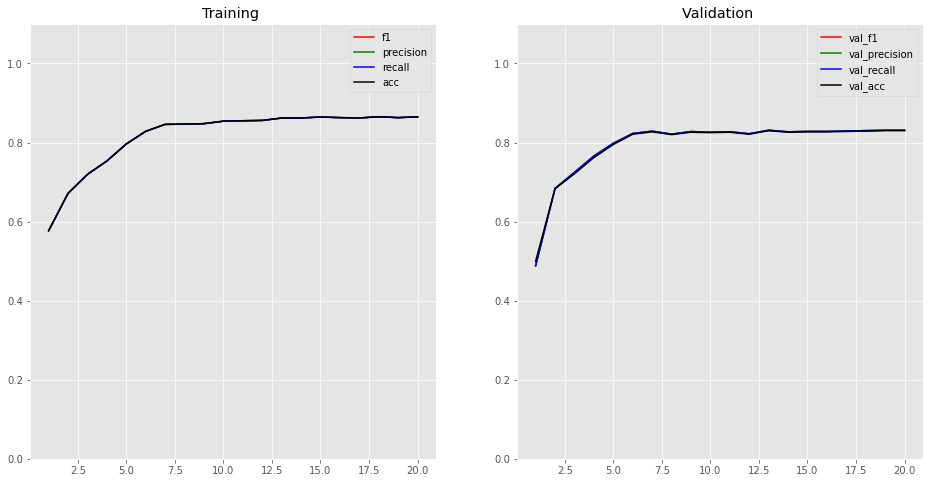

In [85]:
plot_history(history.history)

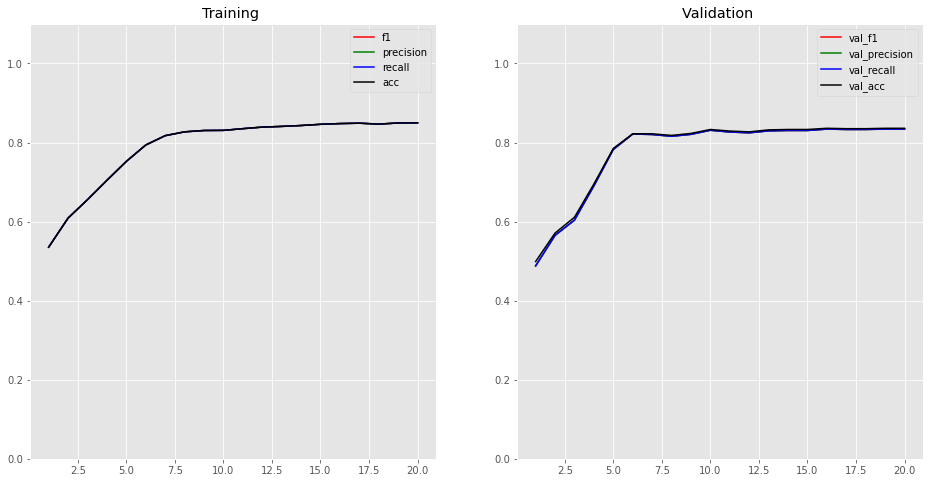

In [81]:
plot_history(history.history)